# Statistiques Exploratoires

In [1]:
# Import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from collections import Counter
from wordcloud import WordCloud
import re
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
nltk.download('stopwords')

nltk.download('punkt')
from nltk.tokenize import word_tokenize


[nltk_data] Error loading stopwords: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:1000)>
[nltk_data] Error loading punkt: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:1000)>


## ISOT

In [22]:
# Loading dataset
df_true = pd.read_csv('data/isot/raw/True.csv')
df_fake = pd.read_csv('data/isot/raw/Fake.csv')
df_combined = pd.concat([df_true, df_fake], ignore_index=True)


In [3]:
df_true.shape, df_fake.shape

((21417, 4), (23481, 4))

In [4]:
df_fake.sample(5)

,title,text,subject,date
11120,DINGBAT MAXINE WATERS Tells Islamic Society Re...,"Is it simply pandering for votes, or is it pos...",politics,"Apr 17, 2017"
22928,EP #19: Patrick Henningsen LIVE – SEASON FINAL...,This is the final episode of Patrick LIVE on ...,Middle-east,"March 30, 2017"
15501,NEW APP GIVES WOMEN OPPORTUNITY TO TALK ABOUT ...,Wow maybe they could include a place where the...,politics,"Jul 7, 2015"
4189,BREAKING: Trump Supporters Busted By FBI For ...,The FBI thwarted an act of domestic terrorism ...,News,"October 14, 2016"
9670,PRESIDENT TRUMP Issues Warning To John McCain ...,President Trump hit back at Senator John McCai...,politics,"Oct 17, 2017"


In [5]:
df_true.sample(5)

,title,text,subject,date
7508,"Tiger tips Clinton, bear backs Trump in Siberi...",(Reuters) - A tiger and polar bear in a Siberi...,politicsNews,"November 8, 2016"
13802,Turkey says U.S. wants use gold trader case to...,ISTANBUL (Reuters) - Turkey s Deputy Prime Min...,worldnews,"November 27, 2017"
11524,"U.N. hails first step on Syria detainees, caut...",GENEVA (Reuters) - U.N. Syria envoy Staffan de...,worldnews,"December 22, 2017"
6809,Trump's threats chill corporate investment pla...,MEXICO CITY (Reuters) - Donald Trump’s threats...,politicsNews,"December 9, 2016"
5486,Trump aide says endorsement of Ivanka's brand ...,WASHINGTON (Reuters) - A top aide to U.S. Pres...,politicsNews,"February 12, 2017"


In [6]:
def remove_intro_and_store_city_source(df):
    # Appliquer la fonction sur chaque ligne de la dataframe
    def process_row(row):
        # Extraire la portion supprimée (avant le premier tiret suivi d'un espace)
        intro = re.match(r'^.*?-\s+', row['text'])
        if intro:
            # Retirer l'intro du texte
            row['text'] = re.sub(r'^.*?-\s+', '', row['text'])
            
            # Extraction de la ville et de la source à partir de la portion supprimée
            match = re.match(r'([A-Za-z\s]+)\s\(([^)]+)\)\s-\s', intro.group(0))
            if match:
                # Extraire la ville et la source
                row['city'] = match.group(1).strip()
                row['source_name'] = match.group(2).strip()
            else:
                row['city'] = np.nan
                row['source_name'] = np.nan
        else:
            # Si aucune intro n'est trouvée, ne rien changer
            row['city'] = ''
            row['source_name'] = ''
        
        return row
    
    # Appliquer cette fonction à chaque ligne du DataFrame
    df = df.apply(process_row, axis=1)
    return df



In [23]:
df = remove_intro_and_store_city_source(df_combined)


In [ ]:
df

,title,text,subject,date,city,source_name
0,"As U.S. budget fight looms, Republicans flip t...",The head of a conservative Republican faction ...,politicsNews,"December 31, 2017",WASHINGTON,Reuters
1,U.S. military to accept transgender recruits o...,Transgender people will be allowed for the fir...,politicsNews,"December 29, 2017",WASHINGTON,Reuters
2,Senior U.S. Republican senator: 'Let Mr. Muell...,The special counsel investigation of links bet...,politicsNews,"December 31, 2017",WASHINGTON,Reuters
3,FBI Russia probe helped by Australian diplomat...,Trump campaign adviser George Papadopoulos tol...,politicsNews,"December 30, 2017",WASHINGTON,Reuters
4,Trump wants Postal Service to charge 'much mor...,President Donald Trump called on the U.S. Post...,politicsNews,"December 29, 2017",NaN,NaN
...,...,...,...,...,...,...
44893,McPain: John McCain Furious That Iran Treated ...,21st Century Wire says As 21WIRE reported earl...,Middle-east,"January 16, 2016",,
44894,JUSTICE? Yahoo Settles E-mail Privacy Class-ac...,21st Century Wire says It s a familiar theme. ...,Middle-east,"January 16, 2016",,
44895,Sunnistan: US and Allied ‘Safe Zone’ Plan to T...,Patrick Henningsen 21st Century WireRemember ...,Middle-east,"January 15, 2016",,
44896,How to Blow $700 Million: Al Jazeera America F...,21st Century Wire says Al Jazeera America will...,Middle-east,"January 14, 2016",,


# STAT Générale

In [25]:
# Taille du dataset
print("Dataset articles : TRUE")
print(f"Nombre total d'articles : {len(df)}")

# Longueur des textes et titres
df['text_length'] = df['text'].apply(lambda x: len(str(x)))
df['text_wordcount'] = df['text'].apply(lambda x: len(str(x).split()))
df['title_wordcount'] = df['title'].apply(lambda x: len(str(x).split()))

# Stats descriptives
print(df[['text_wordcount', 'title_wordcount']].describe())


Dataset articles : TRUE
Nombre total d'articles : 44898
       text_wordcount  title_wordcount
count    44898.000000     44898.000000
mean       398.850906        12.453472
std        338.288635         4.111476
min          0.000000         1.000000
25%        197.000000        10.000000
50%        358.000000        11.000000
75%        507.750000        14.000000
max       8135.000000        42.000000


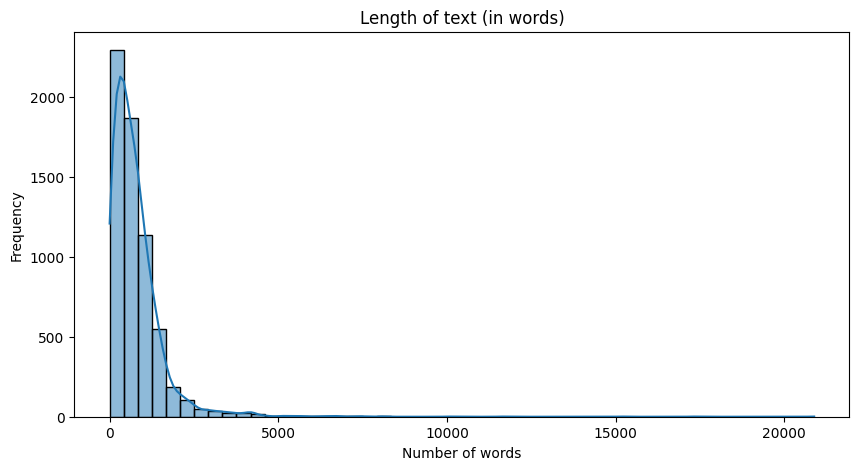

In [40]:
# Histogramme des longueurs de texte
plt.figure(figsize=(10,5))
sns.histplot(df['text_wordcount'], bins=50, kde=True)
plt.title("Length of text (in words)")
plt.xlabel("Number of words")
plt.ylabel("Frequency")
plt.show()


# Catégorie / Topic

subject
politicsNews       11272
worldnews          10145
News                9050
politics            6841
left-news           4459
Government News     1570
US_News              783
Middle-east          778
Name: count, dtype: int64
city
              22986
WASHINGTON     6444
NEW YORK        734
LONDON          709
MOSCOW          624
Name: count, dtype: int64
source_name
                              22986
Reuters                       17215
Thomson Reuters Foundation        7
IFR                               3
Reuters on Friday                 1
Name: count, dtype: int64


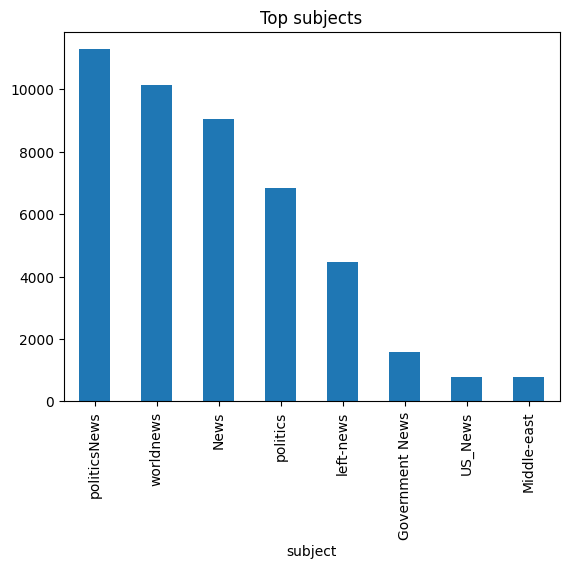

In [29]:
# Top sujets
print(df['subject'].value_counts())
df['subject'].value_counts().plot(kind='bar', title="Top subjects")

# Top villes et sources
print(df['city'].value_counts().head())
print(df['source_name'].value_counts().head())


<Axes: title={'center': 'articles per year'}, xlabel='year'>

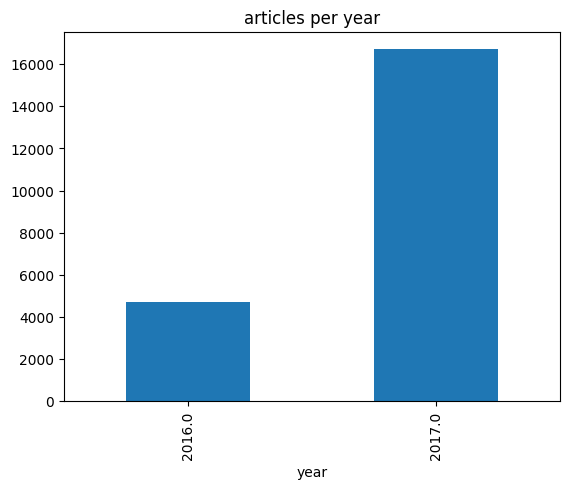

In [30]:
df['date'] = pd.to_datetime(df['date'], errors='coerce')

# Nombre d’articles par année
df['year'] = df['date'].dt.year
df['year'].value_counts().sort_index().plot(kind='bar', title="articles per year")

# Clouds

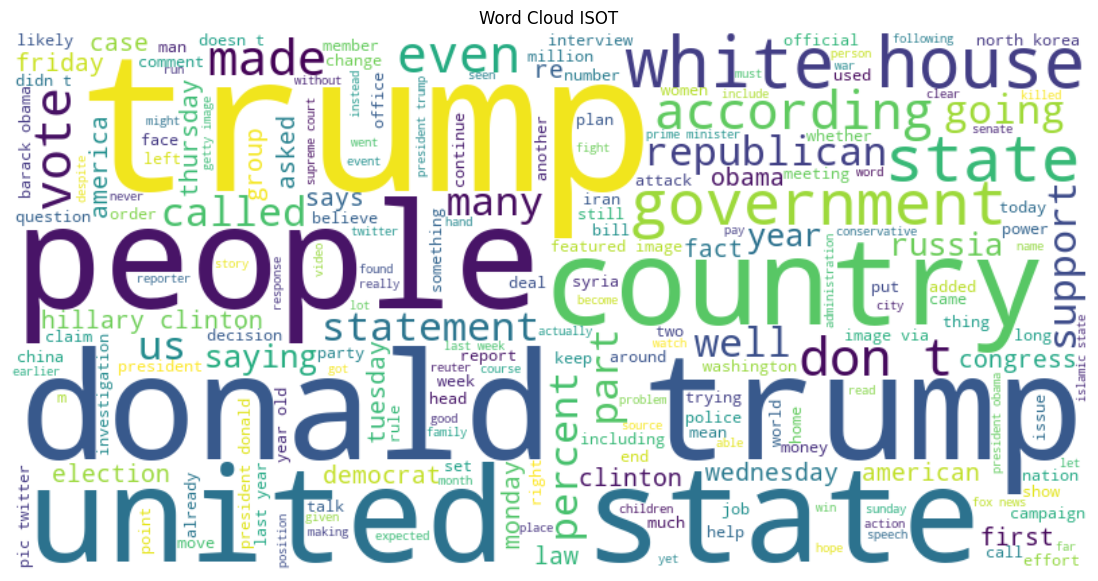

In [33]:
# Liste des mots à supprimer
custom_stopwords = {'s', 'said', 'u', 'new', 'told', 'will', 'now', 'one','may', 'say', 'need', 'way', 'also', 'get', 'go', 'see', 'know', 'come', 'take', 'make', 'want', 'like', 'time', 'think', 'use', 'work', 'look', 'back', 'give', 'tell', 'find', 'day', 'way'}

# Construction du corpus nettoyé
text_corpus = ' '.join(df['text'].dropna().astype(str))

# Nettoyage : suppression manuelle des mots
tokens = re.findall(r'\b\w+\b', text_corpus.lower())
filtered_tokens = [word for word in tokens if word not in custom_stopwords]
cleaned_text = ' '.join(filtered_tokens)

# Génération du nuage de mots
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(cleaned_text)

# Affichage
plt.figure(figsize=(15, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Word Cloud ISOT")
plt.show()


# Croisements

In [34]:
# Nombre d’articles par sujet et source
pivot = pd.pivot_table(df, index='subject', columns='source_name', aggfunc='size', fill_value=0)
print(pivot.head())

# Longueur moyenne du texte par sujet
print(df.groupby('subject')['text_wordcount'].mean())


source_name            IFR  LPC/IFR  Reuters  Reuters on Friday  \
subject                                                           
Government News  1538    0        0        0                  0   
Middle-east       755    0        0        0                  0   
News             8892    0        0        0                  0   
US_News           760    0        0        0                  0   
left-news        4333    0        0        0                  0   

source_name      Thomson Reuters Foundation  
subject                                      
Government News                           0  
Middle-east                               0  
News                                      0  
US_News                                   0  
left-news                                 0  
subject
Government News    378.568790
Middle-east        743.501285
News               437.046298
US_News            751.665390
left-news          380.824176
politics           337.440140
politicsNews       4

# Données manquantes

In [35]:
# Valeurs manquantes
print(df.isnull().sum())

# Pourcentage de manquant
print((df.isnull().mean() * 100).round(2))


title                  0
text                   0
subject                0
date               23481
city                4685
source_name         4685
text_length            0
text_wordcount         0
title_wordcount        0
year               23481
dtype: int64
title               0.00
text                0.00
subject             0.00
date               52.30
city               10.43
source_name        10.43
text_length         0.00
text_wordcount      0.00
title_wordcount     0.00
year               52.30
dtype: float64


## Kaggle

In [36]:
df = pd.read_csv('data/kaggle/raw/fake_or_real_news.csv')

In [37]:
df.sample(5)

,Unnamed: 0,title,text,label
6109,7655,Apostate Evangelicals Are Poised To Become The...,"Posted on October 28, 2016 by Michael Snyder \...",FAKE
1232,3778,Patriots Day 2015: Boston does not stand alone,In the two years since the horrific marathon b...,REAL
2068,1450,GOP candidates fight for spotlight ahead of Mi...,The leading Republican presidential candidates...,REAL
5368,7257,Deepwater Horizon Continues to Impact Public H...,Deepwater Horizon Continues to Impact Public H...,FAKE
342,5914,NOW FIVE FBI FIELD OFFICES ARE PROBING CLINTON...,Home › POLITICS › NOW FIVE FBI FIELD OFFICES A...,FAKE


In [38]:
# Taille du dataset
print("Dataset articles : TRUE")
print(f"Nombre total d'articles : {len(df)}")

# Longueur des textes et titres
df['text_length'] = df['text'].apply(lambda x: len(str(x)))
df['text_wordcount'] = df['text'].apply(lambda x: len(str(x).split()))
df['title_wordcount'] = df['title'].apply(lambda x: len(str(x).split()))

# Stats descriptives
print(df[['text_wordcount', 'title_wordcount']].describe())


Dataset articles : TRUE
Nombre total d'articles : 6335
       text_wordcount  title_wordcount
count     6335.000000      6335.000000
mean       776.300710        10.496448
std        854.333358         3.985165
min          0.000000         1.000000
25%        289.000000         8.000000
50%        597.000000        10.000000
75%       1024.000000        13.000000
max      20891.000000        53.000000


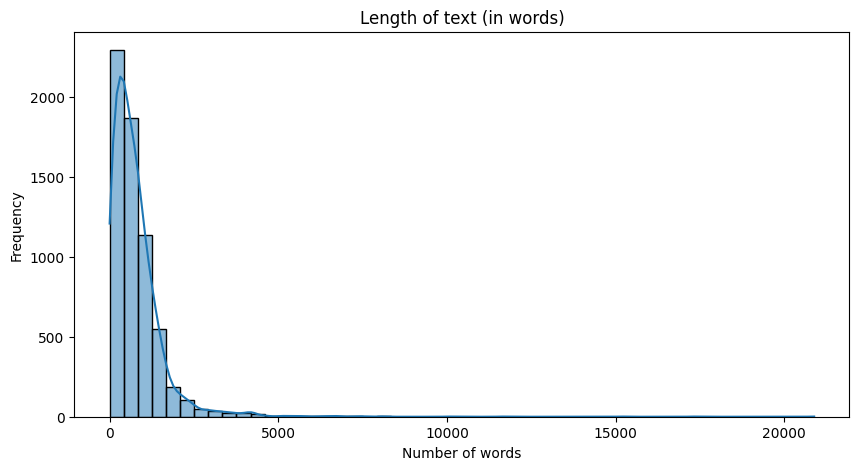

In [41]:
# Histogramme des longueurs de texte
plt.figure(figsize=(10,5))
sns.histplot(df['text_wordcount'], bins=50, kde=True)
plt.title("Length of text (in words)")
plt.xlabel("Number of words")
plt.ylabel("Frequency")
plt.show()


# Analyse du contenu 

# Nuage de mots

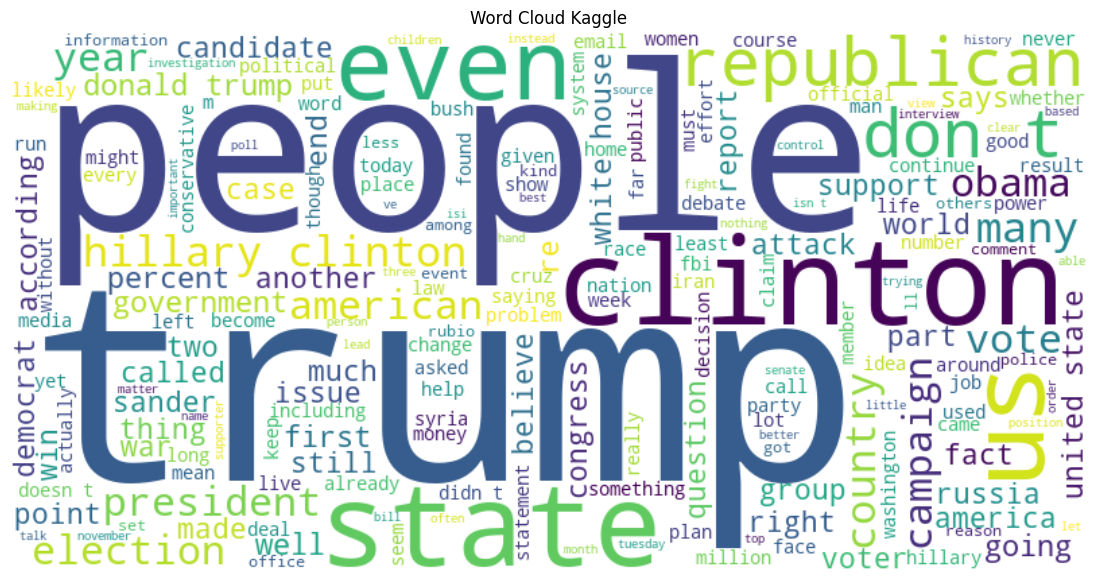

In [43]:
# Liste des mots à supprimer
custom_stopwords = {'s', 'said', 'u', 'new', 'told', 'will', 'now', 'one','may', 'say', 'need', 'way', 'also', 'get', 'go', 'see', 'know', 'come', 'take', 'make', 'want', 'like', 'time', 'think', 'use', 'work', 'look', 'back', 'give', 'tell', 'find', 'day', 'way'}

# Construction du corpus nettoyé
text_corpus = ' '.join(df['text'].dropna().astype(str))

# Nettoyage : suppression manuelle des mots
tokens = re.findall(r'\b\w+\b', text_corpus.lower())
filtered_tokens = [word for word in tokens if word not in custom_stopwords]
cleaned_text = ' '.join(filtered_tokens)

# Génération du nuage de mots
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(cleaned_text)

# Affichage
plt.figure(figsize=(15, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Word Cloud Kaggle")
plt.show()